# Actividad con datos de Ecobici (CDMX)

Se realizó el **ETL (Extract, Transform, Load)** con el dataset de Ecobici de la Ciudad de México.  
- Se cargó y limpio los datos.  
- Calcular la **duración de cada viaje en minutos**.  
- **Discretizar** la duración en categorías (corto, mediano, largo, muy largo).  
- **One Hot Encoding** y normalización


In [16]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import unicodedata, re

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carga del dataset
- Se carga el archivo `2025-01.csv`

- Se revisa el número de filas, columnas y los nombres de las variables disponibles.


In [17]:
file_path = '/content/drive/MyDrive/Module1-python/ecobici/2025-01.csv'
df = pd.read_csv(file_path)

print("Número de filas y columnas:", df.shape)
print("Columnas disponibles:", df.columns.tolist())
df.head()

Número de filas y columnas: (1809775, 9)
Columnas disponibles: ['Genero_Usuario', 'Edad_Usuario', 'Bici', 'Ciclo_Estacion_Retiro', 'Fecha_Retiro', 'Hora_Retiro', 'Ciclo_EstacionArribo', 'Fecha_Arribo', 'Hora_Arribo']


,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_EstacionArribo,Fecha_Arribo,Hora_Arribo
0,M,26.0,5180930,568,31/12/2024,23:57:02,572,01/01/2025,00:00:03
1,F,54.0,3653953,283,31/12/2024,23:51:40,596,01/01/2025,00:00:41
2,M,38.0,7511322,034,31/12/2024,23:48:36,064,01/01/2025,00:00:59
3,M,41.0,3804572,258,31/12/2024,23:54:11,023,01/01/2025,00:01:08
4,M,35.0,3848405,043,31/12/2024,23:35:28,126,01/01/2025,00:01:17


## Limpieza de datos
- Revisión de tipos de datos.  
- Conteo de valores nulos.  
- Eliminación de duplicados.  
- Manejo de valores nulos.


In [18]:
# Tipos de datos
df.info()
# Conteo de nulos
print("\nValores nulos por columna:\n", df.isnull().sum())
# Eliminar duplicados
df = df.drop_duplicates()
# Eliminar filas con nulos
df = df.dropna()
print("\nShape final después de limpieza:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1809775 entries, 0 to 1809774
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Genero_Usuario         object 
 1   Edad_Usuario           float64
 2   Bici                   int64  
 3   Ciclo_Estacion_Retiro  object 
 4   Fecha_Retiro           object 
 5   Hora_Retiro            object 
 6   Ciclo_EstacionArribo   object 
 7   Fecha_Arribo           object 
 8   Hora_Arribo            object 
dtypes: float64(1), int64(1), object(7)
memory usage: 124.3+ MB

Valores nulos por columna:
 Genero_Usuario             1
Edad_Usuario             147
Bici                       0
Ciclo_Estacion_Retiro      0
Fecha_Retiro               0
Hora_Retiro                0
Ciclo_EstacionArribo       0
Fecha_Arribo               0
Hora_Arribo                0
dtype: int64

Shape final después de limpieza: (1809628, 9)


## Normalización de nombres de columnas
Para la normalización se convirtió todas las columnas a minúsculas, sin acentos y reemplazando espacios por guiones bajos para evitar errores.


In [19]:
def normalize_col(s):
    s = s.strip()
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("utf-8")
    s = s.lower()
    s = re.sub(r"[^a-z0-9]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s

df.columns = [normalize_col(c) for c in df.columns]
print("Columnas normalizadas:", df.columns.tolist())

Columnas normalizadas: ['genero_usuario', 'edad_usuario', 'bici', 'ciclo_estacion_retiro', 'fecha_retiro', 'hora_retiro', 'ciclo_estacionarribo', 'fecha_arribo', 'hora_arribo']


## Cálculo de la duración del viaje (`tiempo_uso_min`)
Aqui se une la fecha y hora de retiro/arribo, calculando la duración en minutos y limpiando los valores negativos o viajes mayores a 24 horas.


In [20]:
# Construcción de columnas datetime
start_dt = pd.to_datetime(df['fecha_retiro'].astype(str) + " " + df['hora_retiro'].astype(str),
                          dayfirst=True, errors='coerce')
end_dt   = pd.to_datetime(df['fecha_arribo'].astype(str) + " " + df['hora_arribo'].astype(str),
                          dayfirst=True, errors='coerce')

df['tiempo_uso_min'] = (end_dt - start_dt).dt.total_seconds() / 60.0

# Limpieza
df = df[df['tiempo_uso_min'].notna()]
df['tiempo_uso_min'] = df['tiempo_uso_min'].clip(lower=0)
df = df[df['tiempo_uso_min'].between(0, 24*60, inclusive='both')]

print(df['tiempo_uso_min'].describe().round(2))
df[['fecha_retiro','hora_retiro','fecha_arribo','hora_arribo','tiempo_uso_min']].head()

count    1809583.00
mean          15.00
std           13.21
min            0.32
25%            7.10
50%           11.90
75%           19.80
max         1436.88
Name: tiempo_uso_min, dtype: float64


,fecha_retiro,hora_retiro,fecha_arribo,hora_arribo,tiempo_uso_min
0,31/12/2024,23:57:02,01/01/2025,00:00:03,3.016667
1,31/12/2024,23:51:40,01/01/2025,00:00:41,9.016667
2,31/12/2024,23:48:36,01/01/2025,00:00:59,12.383333
3,31/12/2024,23:54:11,01/01/2025,00:01:08,6.950000
4,31/12/2024,23:35:28,01/01/2025,00:01:17,25.816667


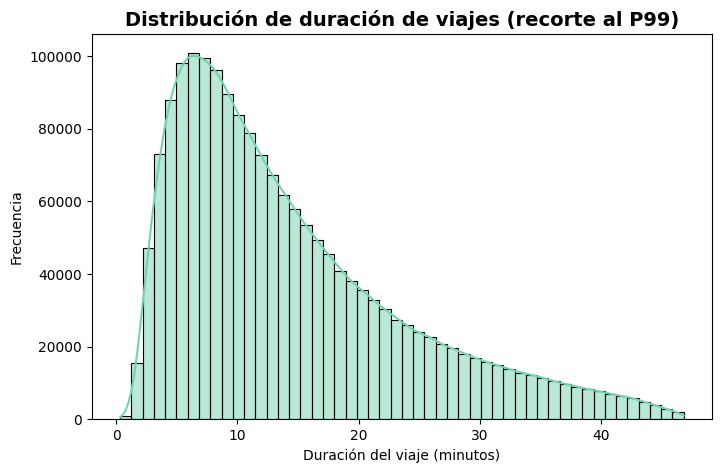

In [28]:
# Histograma de tiempo de uso (recorte P99)
p99 = df['tiempo_uso_min'].quantile(0.99)
plt.figure(figsize=(8,5))
sns.histplot(df[df['tiempo_uso_min'] <= p99]['tiempo_uso_min'], bins=50, color="#74D3AE", kde=True)

plt.title("Distribución de duración de viajes (recorte al P99)", fontsize=14, weight="bold")
plt.xlabel("Duración del viaje (minutos)")
plt.ylabel("Frecuencia")
plt.show()


## Discretización de la duración de viajes
Se crean categorías de viaje según la duración en minutos:  
- **Corto**: 0–10 min  
- **Mediano**: 10–20 min  
- **Largo**: 20–40 min  
- **Muy largo**: más de 40 min  


In [21]:
bins   = [0, 10, 20, 40, np.inf]
labels = ['Corto', 'Mediano', 'Largo', 'Muy_largo']

df['categoria_viaje'] = pd.cut(df['tiempo_uso_min'], bins=bins, labels=labels, include_lowest=True)
df['categoria_viaje'] = pd.Categorical(df['categoria_viaje'], categories=labels, ordered=True)

df[['tiempo_uso_min','categoria_viaje']].head()

,tiempo_uso_min,categoria_viaje
0,3.016667,Corto
1,9.016667,Corto
2,12.383333,Mediano
3,6.950000,Corto
4,25.816667,Largo


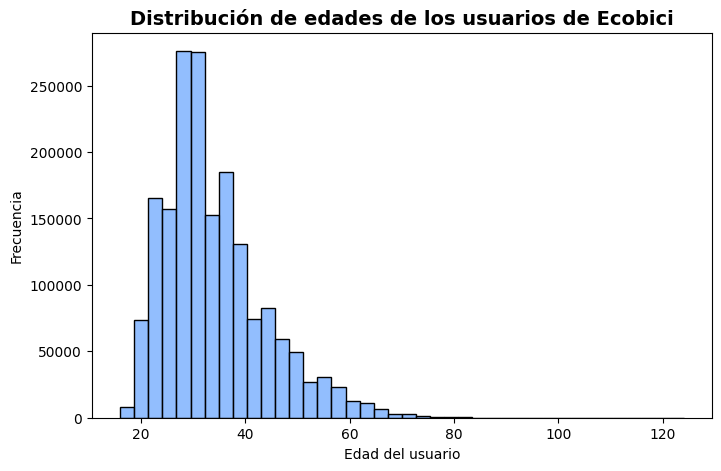

In [30]:
plt.figure(figsize=(8,5))
sns.histplot(df['edad_usuario'], bins=40, color="#6EA8FE", kde=False)

plt.title("Distribución de edades de los usuarios de Ecobici", fontsize=14, weight="bold")
plt.xlabel("Edad del usuario")
plt.ylabel("Frecuencia")
plt.show()

## Cantidad de viajes por categoría

,Conteo,Porcentaje (%)
categoria_viaje,,
Corto,745500,41.2
Mediano,619972,34.3
Largo,391077,21.6
Muy_largo,53034,2.9


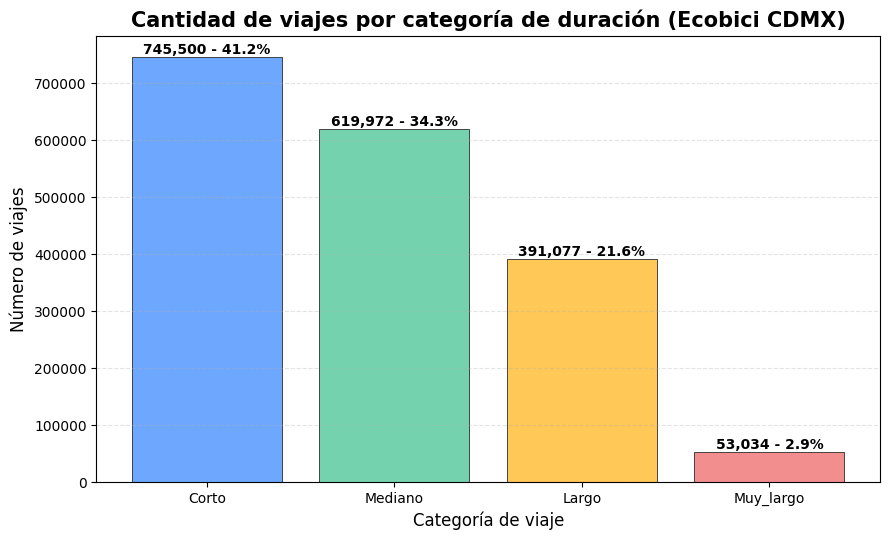

In [23]:
counts = df['categoria_viaje'].value_counts().reindex(labels, fill_value=0)
perc   = (counts / counts.sum() * 100).round(1)

tabla_categorias = pd.DataFrame({'Conteo': counts, 'Porcentaje (%)': perc})
display(tabla_categorias)

colors = ['#6EA8FE', '#74D3AE', '#FFC857', '#F28E8E']
plt.figure(figsize=(9,5.5))
bars = plt.bar(labels, counts.values, color=colors, edgecolor='#2b2b2b', linewidth=0.6)

plt.title("Cantidad de viajes por categoría de duración (Ecobici CDMX)", fontsize=15, weight="bold")
plt.xlabel("Categoría de viaje", fontsize=12)
plt.ylabel("Número de viajes", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.35)

# Etiquetas
for rect, c, p in zip(bars, counts.values, perc.values):
    plt.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
             f"{c:,} - {p:.1f}%", ha="center", va="bottom", fontsize=10, weight="bold")

plt.tight_layout()
plt.show()

## One-Hot Encoding
Se transformo la variable `categoria_viaje` en variables dummy para que pueda ser utilizada en modelos de Machine Learning

In [24]:
df = pd.get_dummies(df, columns=['categoria_viaje'], prefix='cat')
df.head()

,genero_usuario,edad_usuario,bici,ciclo_estacion_retiro,fecha_retiro,hora_retiro,ciclo_estacionarribo,fecha_arribo,hora_arribo,tiempo_uso_min,cat_Corto,cat_Mediano,cat_Largo,cat_Muy_largo
0,M,26.0,5180930,568,31/12/2024,23:57:02,572,01/01/2025,00:00:03,3.016667,True,False,False,False
1,F,54.0,3653953,283,31/12/2024,23:51:40,596,01/01/2025,00:00:41,9.016667,True,False,False,False
2,M,38.0,7511322,034,31/12/2024,23:48:36,064,01/01/2025,00:00:59,12.383333,False,True,False,False
3,M,41.0,3804572,258,31/12/2024,23:54:11,023,01/01/2025,00:01:08,6.950000,True,False,False,False
4,M,35.0,3848405,043,31/12/2024,23:35:28,126,01/01/2025,00:01:17,25.816667,False,False,True,False


## Normalización de variables numéricas
Se normalizan las variables numéricas (`edad_usuario`, `tiempo_uso_min`) en nuevas columnas terminadas en `_norm` para llevarlas al rango [0,1].


In [25]:
scaler = MinMaxScaler()

for col in ['edad_usuario','tiempo_uso_min']:
    if col in df.columns:
        df[col + '_norm'] = scaler.fit_transform(df[[col]])

df[['edad_usuario','edad_usuario_norm','tiempo_uso_min','tiempo_uso_min_norm']].head()

,edad_usuario,edad_usuario_norm,tiempo_uso_min,tiempo_uso_min_norm
0,26.0,0.092593,3.016667,0.001879
1,54.0,0.351852,9.016667,0.006056
2,38.0,0.203704,12.383333,0.008400
3,41.0,0.231481,6.950000,0.004617
4,35.0,0.175926,25.816667,0.017751


## Resumen

In [26]:
print("Resumen de variables numéricas:")
display(df[['edad_usuario','tiempo_uso_min']].describe().round(2))

print("\nDistribución de categorías (dummies en %):")
display(df.filter(like='cat_').mean().round(3) * 100)


Resumen de variables numéricas:


,edad_usuario,tiempo_uso_min
count,1809583.0,1809583.00
mean,34.0,15.00
std,9.8,13.21
min,16.0,0.32
25%,27.0,7.10
50%,32.0,11.90
75%,39.0,19.80
max,124.0,1436.88



Distribución de categorías (dummies en %):


,0
cat_Corto,41.2
cat_Mediano,34.3
cat_Largo,21.6
cat_Muy_largo,2.9


## Conclusiones

- El dataset final incluye **1,809,583 viajes** limpios y procesados de Ecobici CDMX.  
- La **duración promedio** de los viajes es de **15 minutos**, con una mediana de **11.9 minutos**, lo que confirma que la mayoría de los traslados son **breves**.  
- La categoría más frecuente es **“Corto (0–10 min)”** con **41.2%** de los viajes, seguida por **Mediano (10–20 min)** con **34.3%**, lo que en conjunto representa más de **tres cuartas partes de los viajes**.  
- Los viajes **largos (20–40 min)** representan un **21.6%**, mientras que los **muy largos (>40 min)** son minoritarios con **2.9%**, lo que indica que el sistema se utiliza principalmente para trayectos de corta y mediana distancia.  
- Tras aplicar **One-Hot Encoding y normalización**, el dataset queda listo para su uso en **modelos de análisis y predicción de movilidad urbana**.  

En resumen, Ecobici en CDMX se caracteriza por viajes cortos y medianos, lo que refleja su papel como alternativa de transporte rápido y complementario en la ciudad.


In [27]:
# Guardar dataset final procesado
output_path = '/content/drive/MyDrive/Module1-python/ecobici/etl_ecobici.csv'
df.to_csv(output_path, index=False)
print("Archivo guardado en:", output_path)

Archivo guardado en: /content/drive/MyDrive/Module1-python/ecobici/etl_ecobici.csv
